In [67]:
import torch
from torch import nn
from load_mnist import load_mnist
import matplotlib.pyplot as plt
import numpy as np
from time import time
np.random.seed(0)

## 1.1 Multi Layer Fully Connected Network

In [88]:
def training_curve_plot(title, train_losses, test_losses, train_accuracy, test_accuracy):
    """ 
    convenience function for plotting train and test loss and accuracy
    """
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].plot(x, train_accuracy, label=f'Final train accuracy: {train_accuracy[-1]:.4f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test accuracy: {test_accuracy[-1]:.4f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Iteration', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

In [93]:
#Network architecture
# Implement a 2-layer neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
       
        return out

In [ ]:
#Load MNIST dataset
x_train, y_train, x_test, y_test = load_mnist()

In [53]:

bz = 64



# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
X_train_3Dtensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1, 28, 28)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
X_train_3Dtensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1, 28, 28)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_set = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
test_set = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=bz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=bz, shuffle=False)

train_3d = torch.utils.data.TensorDataset(X_train_3Dtensor, Y_train_tensor)
train_loader_3d = torch.utils.data.DataLoader(train_3d, batch_size=bz, shuffle=True)
test_3d = torch.utils.data.TensorDataset(X_train_3Dtensor, Y_train_tensor)
test_loader_3d = torch.utils.data.DataLoader(test_3d, batch_size=bz, shuffle=False)

In [97]:
def train_network(model: nn.Module, criteria: nn.Module, 
                  optimizer: torch.optim.Optimizer, num_epochs: int, train_loader: torch.utils.data.DataLoader, 
                  test_loader: torch.utils.data.DataLoader, device: torch.device, model_name: str, lr: float) -> None:
    """
    Train a neural network model
    
    Args:
        model: The neural network model to be trained
        criteria: The loss function
        optimizer: The optimizer
        num_epochs: The number of epochs to train the model
        train_loader: The training data loader
        test_loader: The test data loader
        device: The device to run the model on
    """
    train_costs = []
    test_costs = []
    train_accuracy = []
    test_accuracy = []
    start = time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            
            outputs = model(images)
            loss = criteria(outputs, torch.argmax(labels, dim=1))
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
        
        train_costs.append(train_loss / len(train_loader))
        train_accuracy.append(100 * correct / total)
    
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criteria(outputs, torch.argmax(labels, dim=1))
                test_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(torch.argmax(labels, dim=1)).sum().item()
            
            test_costs.append(test_loss / len(test_loader))
            test_accuracy.append(100 * correct / total)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_costs[-1]:.4f}, Test Loss: {test_costs[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}%, Test Accuracy: {test_accuracy[-1]:.4f}%')
    total = time() - start
    
    plot_title = f'{model_name} Training Curve' + '\n'+ f' {num_epochs} epochs,'+ f' {bz} batch size, '+ f' {lr} learning rate, ' + f'total time: {total//60:.2f} Min, {total%60:.2f} Sec' +'\n'
    training_curve_plot(plot_title, train_costs, test_costs, train_accuracy, test_accuracy)
    
            
    

In [92]:
#Hyperparameters
input_size = 28*28
hidden_size_1 = 512
hidden_size_2 = 256
num_classes = 10
num_epochs = 50
learning_rate = 0.01

Epoch 1/50, Train Loss: 1.5688, Test Loss: 0.6723, Train Accuracy: 64.5233%, Test Accuracy: 84.0300%
Epoch 2/50, Train Loss: 0.5119, Test Loss: 0.4002, Train Accuracy: 86.3667%, Test Accuracy: 88.8300%
Epoch 3/50, Train Loss: 0.3797, Test Loss: 0.3392, Train Accuracy: 89.3367%, Test Accuracy: 90.5100%
Epoch 4/50, Train Loss: 0.3334, Test Loss: 0.3086, Train Accuracy: 90.4600%, Test Accuracy: 91.0400%
Epoch 5/50, Train Loss: 0.3046, Test Loss: 0.2817, Train Accuracy: 91.2783%, Test Accuracy: 92.0600%
Epoch 6/50, Train Loss: 0.2824, Test Loss: 0.2628, Train Accuracy: 91.8733%, Test Accuracy: 92.5100%
Epoch 7/50, Train Loss: 0.2636, Test Loss: 0.2499, Train Accuracy: 92.4250%, Test Accuracy: 92.8400%
Epoch 8/50, Train Loss: 0.2465, Test Loss: 0.2340, Train Accuracy: 92.9800%, Test Accuracy: 93.4400%
Epoch 9/50, Train Loss: 0.2310, Test Loss: 0.2203, Train Accuracy: 93.3617%, Test Accuracy: 93.6500%
Epoch 10/50, Train Loss: 0.2165, Test Loss: 0.2066, Train Accuracy: 93.8567%, Test Accuracy

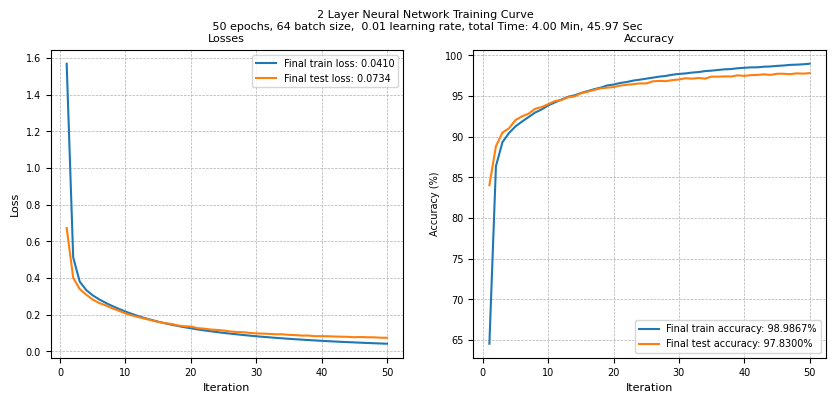

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model_name = '2 Layer Neural Network'
train_network(model, criteria, optimizer, num_epochs, train_loader, test_loader, device, model_name, learning_rate)

## 1.2 Multi-Layer CNN


In [98]:
class mlconvnet(nn.Module):
    def __init__(self):
        super(mlconvnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x


Epoch 1/50, Train Loss: 0.8179, Test Loss: 0.3888, Train Accuracy: 75.7000%, Test Accuracy: 86.5867%
Epoch 2/50, Train Loss: 0.2582, Test Loss: 0.2060, Train Accuracy: 92.0817%, Test Accuracy: 93.9050%
Epoch 3/50, Train Loss: 0.1820, Test Loss: 0.1606, Train Accuracy: 94.5367%, Test Accuracy: 95.2033%
Epoch 4/50, Train Loss: 0.1392, Test Loss: 0.1473, Train Accuracy: 95.8033%, Test Accuracy: 95.5167%
Epoch 5/50, Train Loss: 0.1134, Test Loss: 0.1216, Train Accuracy: 96.5183%, Test Accuracy: 96.3750%
Epoch 6/50, Train Loss: 0.0967, Test Loss: 0.0830, Train Accuracy: 97.0250%, Test Accuracy: 97.5333%
Epoch 7/50, Train Loss: 0.0858, Test Loss: 0.0768, Train Accuracy: 97.3617%, Test Accuracy: 97.6367%
Epoch 8/50, Train Loss: 0.0779, Test Loss: 0.0801, Train Accuracy: 97.6450%, Test Accuracy: 97.4833%
Epoch 9/50, Train Loss: 0.0715, Test Loss: 0.0694, Train Accuracy: 97.7483%, Test Accuracy: 97.8767%
Epoch 10/50, Train Loss: 0.0667, Test Loss: 0.0667, Train Accuracy: 97.9600%, Test Accuracy

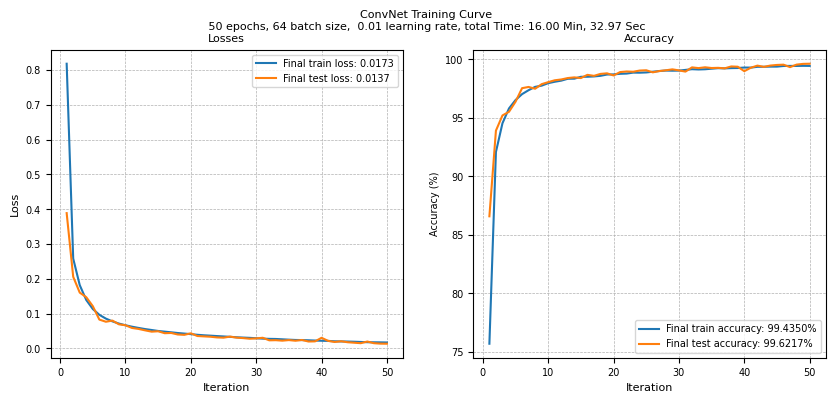

In [99]:
# Create a multi layer conv net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
convenet = mlconvnet().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(convenet.parameters(), lr=learning_rate)
name = 'ConvNet'
train_network(convenet, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)

## 1.3 Swap orders of max pool and activation function

In [103]:
class mlconvnetorderwap(nn.Module):
    def __init__(self):
        super(mlconvnetorderwap, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.ReLU()
       
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
        

        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

Epoch 1/50, Train Loss: 1.0816, Test Loss: 0.3707, Train Accuracy: 66.7683%, Test Accuracy: 89.0467%
Epoch 2/50, Train Loss: 0.2900, Test Loss: 0.2425, Train Accuracy: 91.2083%, Test Accuracy: 92.6567%
Epoch 3/50, Train Loss: 0.2022, Test Loss: 0.1862, Train Accuracy: 93.9333%, Test Accuracy: 94.3617%
Epoch 4/50, Train Loss: 0.1524, Test Loss: 0.1528, Train Accuracy: 95.3083%, Test Accuracy: 95.3650%
Epoch 5/50, Train Loss: 0.1216, Test Loss: 0.1276, Train Accuracy: 96.2633%, Test Accuracy: 96.0117%
Epoch 6/50, Train Loss: 0.1021, Test Loss: 0.1025, Train Accuracy: 96.8850%, Test Accuracy: 96.8400%
Epoch 7/50, Train Loss: 0.0897, Test Loss: 0.0877, Train Accuracy: 97.2883%, Test Accuracy: 97.2717%
Epoch 8/50, Train Loss: 0.0808, Test Loss: 0.0753, Train Accuracy: 97.5817%, Test Accuracy: 97.7233%
Epoch 9/50, Train Loss: 0.0738, Test Loss: 0.0667, Train Accuracy: 97.7317%, Test Accuracy: 98.0083%
Epoch 10/50, Train Loss: 0.0686, Test Loss: 0.0603, Train Accuracy: 97.8850%, Test Accuracy

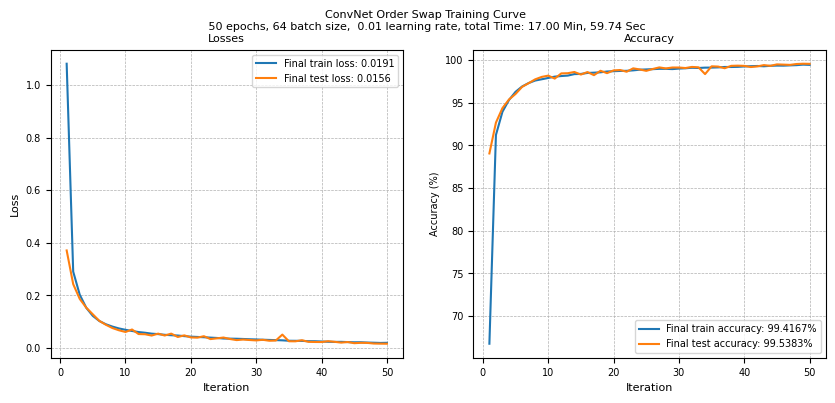

In [104]:
swap = mlconvnetorderwap().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(swap.parameters(), lr=learning_rate)
name = 'ConvNet Order Swap'
train_network(swap, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)


Epoch 1/50, Train Loss: 1.1500, Test Loss: 0.4839, Train Accuracy: 69.4417%, Test Accuracy: 85.9833%
Epoch 2/50, Train Loss: 0.4056, Test Loss: 0.3539, Train Accuracy: 88.0033%, Test Accuracy: 89.4833%
Epoch 3/50, Train Loss: 0.3232, Test Loss: 0.2963, Train Accuracy: 90.4500%, Test Accuracy: 91.0250%
Epoch 4/50, Train Loss: 0.2749, Test Loss: 0.2523, Train Accuracy: 91.8550%, Test Accuracy: 92.5550%
Epoch 5/50, Train Loss: 0.2362, Test Loss: 0.2172, Train Accuracy: 92.9317%, Test Accuracy: 93.5900%
Epoch 6/50, Train Loss: 0.2022, Test Loss: 0.1859, Train Accuracy: 94.0533%, Test Accuracy: 94.6083%
Epoch 7/50, Train Loss: 0.1740, Test Loss: 0.1603, Train Accuracy: 94.8867%, Test Accuracy: 95.2867%
Epoch 8/50, Train Loss: 0.1518, Test Loss: 0.1412, Train Accuracy: 95.5317%, Test Accuracy: 95.8517%
Epoch 9/50, Train Loss: 0.1351, Test Loss: 0.1269, Train Accuracy: 96.0333%, Test Accuracy: 96.3150%
Epoch 10/50, Train Loss: 0.1223, Test Loss: 0.1157, Train Accuracy: 96.4483%, Test Accuracy

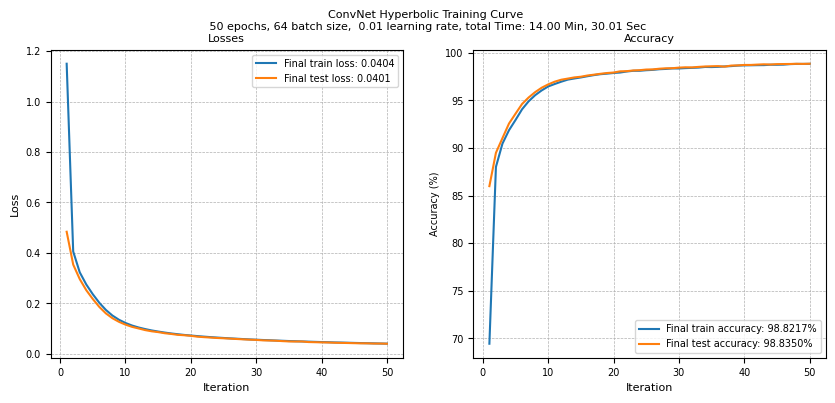

In [111]:
# b) Swap to hyperbolic instead of ReLU activations

class mlconvnethyperbolic(nn.Module):
    def __init__(self):
        super(mlconvnethyperbolic, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.relu1 = nn.Tanh()
        

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.relu2 = nn.Tanh()
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.Tanh()
        self.fc1 = nn.Linear(32*7*7, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu1(x)
    
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

hyperbolic = mlconvnethyperbolic().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(hyperbolic.parameters(), lr=learning_rate)
name = 'ConvNet Hyperbolic'
train_network(hyperbolic, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)

## 1.4 ADAM instead of SGD

Epoch 1/50, Train Loss: 0.1746, Test Loss: 0.0599, Train Accuracy: 96.0267%, Test Accuracy: 98.1117%
Epoch 2/50, Train Loss: 0.0670, Test Loss: 0.0442, Train Accuracy: 98.0000%, Test Accuracy: 98.6367%
Epoch 3/50, Train Loss: 0.0572, Test Loss: 0.0437, Train Accuracy: 98.2033%, Test Accuracy: 98.6117%
Epoch 4/50, Train Loss: 0.0543, Test Loss: 0.0382, Train Accuracy: 98.3550%, Test Accuracy: 98.8517%
Epoch 5/50, Train Loss: 0.0560, Test Loss: 0.0379, Train Accuracy: 98.3133%, Test Accuracy: 98.8333%
Epoch 6/50, Train Loss: 0.0548, Test Loss: 0.0369, Train Accuracy: 98.3700%, Test Accuracy: 98.9100%
Epoch 7/50, Train Loss: 0.0531, Test Loss: 0.0734, Train Accuracy: 98.4100%, Test Accuracy: 97.6917%
Epoch 8/50, Train Loss: 0.0513, Test Loss: 0.0356, Train Accuracy: 98.3950%, Test Accuracy: 99.0167%
Epoch 9/50, Train Loss: 0.0542, Test Loss: 0.0487, Train Accuracy: 98.3533%, Test Accuracy: 98.5367%
Epoch 10/50, Train Loss: 0.0511, Test Loss: 0.0377, Train Accuracy: 98.4717%, Test Accuracy

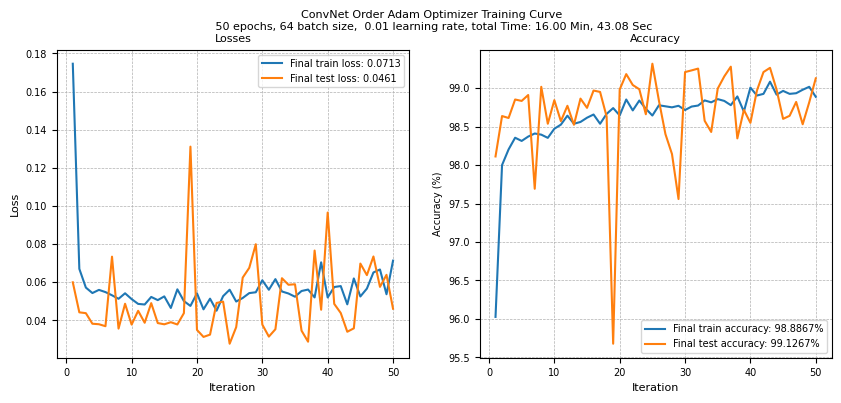

In [107]:
adam_optim = torch.optim.Adam(swap.parameters(), lr=learning_rate)
adam = 'ConvNet Order Adam Optimizer'
train_network(swap, criteria, adam_optim, num_epochs, train_loader_3d, test_loader_3d, device, adam, learning_rate)


## 1.5 CNN three variants
Base model Architecture
 - Conv 8x3x3x1 stride 1 padding 1
 - Relu
 - Pool 

 - Conv 16x3x3x8 stride 1 padding 1
 - Relu
 - Pool

 - Conv 32x3x3x16 stride 1 padding 1
 - Relu
 - FC 32x7x7 in, 10 out

 Optimizer: ADAM
 Loss : Cross Entropy
 Batch size: 16
 Epochs : 50
 
 

### 1.5 a Changing Architexture



Epoch 1/50, Train Loss: 0.1930, Test Loss: 0.0615, Train Accuracy: 93.8300%, Test Accuracy: 98.0517%
Epoch 2/50, Train Loss: 0.0702, Test Loss: 0.0594, Train Accuracy: 97.8033%, Test Accuracy: 98.0967%
Epoch 3/50, Train Loss: 0.0605, Test Loss: 0.0396, Train Accuracy: 98.1800%, Test Accuracy: 98.7533%
Epoch 4/50, Train Loss: 0.0569, Test Loss: 0.0512, Train Accuracy: 98.2517%, Test Accuracy: 98.3200%
Epoch 5/50, Train Loss: 0.0554, Test Loss: 0.0505, Train Accuracy: 98.3267%, Test Accuracy: 98.3367%
Epoch 6/50, Train Loss: 0.0544, Test Loss: 0.0764, Train Accuracy: 98.3383%, Test Accuracy: 97.6800%
Epoch 7/50, Train Loss: 0.0540, Test Loss: 0.0741, Train Accuracy: 98.3950%, Test Accuracy: 97.7533%
Epoch 8/50, Train Loss: 0.0577, Test Loss: 0.0565, Train Accuracy: 98.2517%, Test Accuracy: 98.1750%
Epoch 9/50, Train Loss: 0.0544, Test Loss: 0.0483, Train Accuracy: 98.3433%, Test Accuracy: 98.4233%
Epoch 10/50, Train Loss: 0.0512, Test Loss: 0.0515, Train Accuracy: 98.4217%, Test Accuracy

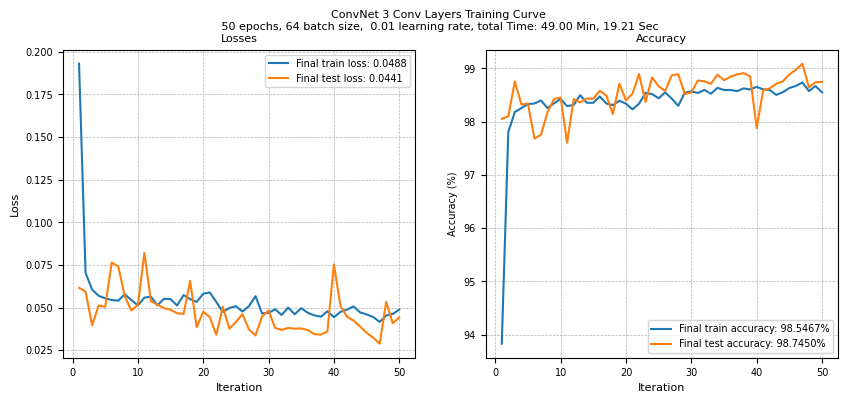

In [110]:
# Change the architecture to have 3 convolutional layers
# and 2 fully connected layers
# and sgd with momemtum optimizer

class mlconvnet3conv(nn.Module):
    def __init__(self):
        super(mlconvnet3conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(32, 64, 3, 1, 1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)

        #fully connected with 64*7*7 input size 10 output size
        self.fc1 = nn.Linear(64*7*7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x
    
conv3 = mlconvnet3conv().to(device)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv3.parameters(), lr=learning_rate)
name = 'ConvNet 3 Conv Layers'
train_network(conv3, criteria, optimizer, num_epochs, train_loader_3d, test_loader_3d, device, name, learning_rate)  



### Confusion Matrix of best performing model & Missclassifications of 10 images


In [ ]:
# PLACEHOLDER